# A qualitative investigation of locality and anti-locality effects with lossy-context surprisal
This thesis aims to investigate whether or not lossy-context surprisal (Futrell et al., 2021), at least qualitatively, has the requisite mechanisms necessary to explain both locality and anti-locality effects and interactions between them within a coherent framework.

In [1]:
import toylossy
import seaborn as sns
import grammars
from nltk.grammar import PCFG
import expdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

My implementation has a progressive noise model where the retention probability of word $w_j$ given that $w_i$ is the last word in the context is given as
$$
e_j = \delta \nu^{i-j}
$$
where $\delta$ is the maximum retention probability and $\nu$ the falloff of the retention probability with increasing distance. In the code these are given as `max_retention_probability` and `rate_falloff` respectively. A symbol that is not retained is simply deleted.

When both $\delta$ and $\nu$ are in the interval $[0;1]$, the retention probability decreases as the distance increases from the word to be predicted.

The language model $L$ is given as a probabilistic context-free grammar. These can be found in the main thesis document.

## The syntactic complexity of Russian relative clauses

In [2]:
pcfg_russian = PCFG.fromstring(
    grammars.gen_russian_grammar_exp2(
        p_src = 0.58, 
        p_src_local = 0.99,
        p_src_case_marked = 0.9,
        p_orc_local = 0.36,
        p_orc_case_marked = 0.83,
        p_one_arg = 0.97, 
        p_adj_interveners = 0.16, 
        p_one_adj = 0.95
    )
)

del_rate = 0.4
max_retention_probability = 1-del_rate
rate_falloff = 0.9

max_depth = None

model_russian = toylossy.ProgressiveNoiseModel(pcfg_russian, max_retention_probability, rate_falloff, max_depth = max_depth)

The parameters were chosen in accordance with the corpus study results of Levy et al. (2013), as reported in Table 1 (p. 467). $p(\text{SRC})=\frac{163}{279}\approx 0.58$, $p(\text{SRC Local})=\frac{154}{163}\approx 0.94$, $p(\text{ORC Local})=\frac{42}{116}\approx 0.36$, $p(\text{SRC case marked})=\frac{154+9}{182}\approx 0.9$, $p(\text{ORC case marked})=\frac{42+74}{139}\approx 0.83$.

The other probabilities were calculated using Universal Dependencies (see the very end of this notebook for the used queries). See the document `pcfg_probs.md` for the method used.

### Experiment 1
In this experiment, local and non-local RC configurations were tested to ascertain the reading time at the verb, first and foremost. The results were the following:

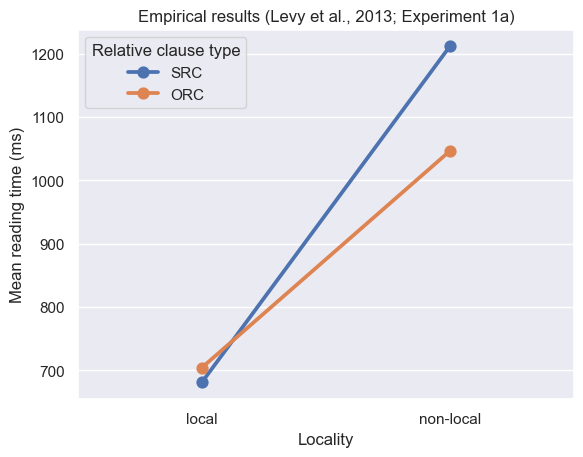

In [3]:
sns.set_theme()

sns.pointplot(expdata.levy_exp1a_verb,
              x = "Locality", 
              y = "Mean reading time (ms)", 
              hue = "Relative clause type"
).set_title("Empirical results (Levy et al., 2013; Experiment 1a)");

I run the model with the parameters as assigned below:

In [4]:
print(f"delta = {max_retention_probability}")
print(f"nu = {rate_falloff}")

delta = 0.6
nu = 0.9


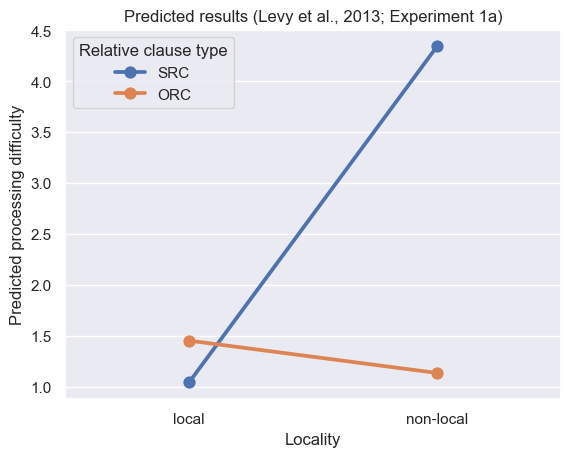

In [5]:
src_local = model_russian.calculate_processing_difficulty("RPNom V".split(), False)
src_non_local = model_russian.calculate_processing_difficulty("RPNom DO V".split())

orc_local = model_russian.calculate_processing_difficulty("RPAcc V".split())
orc_non_local = model_russian.calculate_processing_difficulty("RPAcc Subj V".split(), False)

sim_data_exp1a = pd.DataFrame({
    "Predicted processing difficulty": [src_local, src_non_local, orc_local, orc_non_local],
    "Relative clause type": ["SRC", "SRC", "ORC", "ORC"],
    "Locality": ["local", "non-local", "local", "non-local"]
})

sns.pointplot(sim_data_exp1a,
              x = "Locality", 
              y = "Predicted processing difficulty", 
              hue = "Relative clause type"
).set_title("Predicted results (Levy et al., 2013; Experiment 1a)");

We can look at how changing `max_retention_probability` and `rate_falloff` influences the difference between local and non-local ORCs.

In [17]:
def gen_diffs(sequence1: list[str], 
              sequence2: list[str],
              pcfg: PCFG,
              max_retention_probabilities: np.array,
              rate_falloffs: np.array,
              max_depth = None):
    diffs = np.zeros((len(max_retention_probabilities), len(rate_falloffs)))
    model = toylossy.ProgressiveNoiseModel(pcfg, 0, 0, max_depth = max_depth)
    for (i, max_rp) in tqdm(enumerate(max_retention_probabilities)):
        for (j, rf) in enumerate(rate_falloffs):
            model.set_max_retention_probability(max_rp)
            model.set_rate_falloff(rf)
            diff = model.calculate_processing_difficulty(sequence1) - model.calculate_processing_difficulty(sequence2)
            diffs[i, j] = diff

    return diffs

step = 0.01

max_retention_probabilities = np.arange(0, 1.0 + step, step)
rate_falloffs = np.arange(0, 1 + step, step)

from matplotlib.colors import CenteredNorm

yticklabels = [f"{val:.2f}" if i % 5 == 0 else "" for (i, val) in enumerate(max_retention_probabilities)]
xticklabels = [f"{val:.2f}" if i % 5 == 0 else "" for (i, val) in enumerate(rate_falloffs)]

yticklabels_mulmaps = [f"{val:.2f}" if i % 10 == 0 else "" for (i, val) in enumerate(max_retention_probabilities)]
xticklabels_mulmaps = [f"{val:.2f}" if i % 25 == 0 else "" for (i, val) in enumerate(rate_falloffs)]

norm = CenteredNorm(vcenter = 0)

In [7]:
diffs_orcs_russian = gen_diffs("RPAcc Subj V".split(), "RPAcc V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_srcs_russian = gen_diffs("RPNom DO V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

101it [01:19,  1.27it/s]
101it [01:15,  1.34it/s]


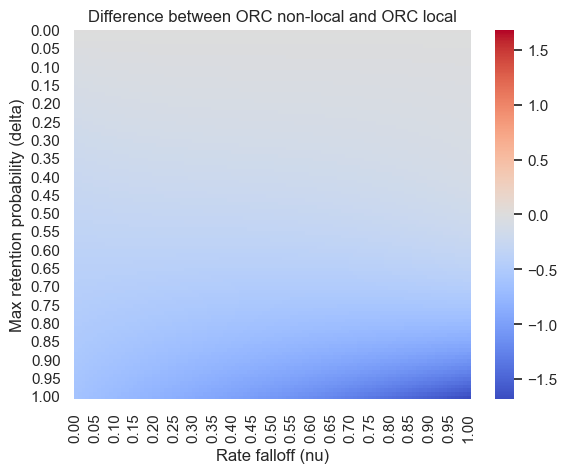

In [8]:
sns.heatmap(
    diffs_orcs_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between ORC non-local and ORC local",
    xlabel = "Rate falloff (nu)",
    ylabel = "Max retention probability (delta)"
);

For ORCs, the model consistently predicts anti-locality. This goes against the empirical results of Levy et al. (2013), who found locality for both SRCs and ORCs.

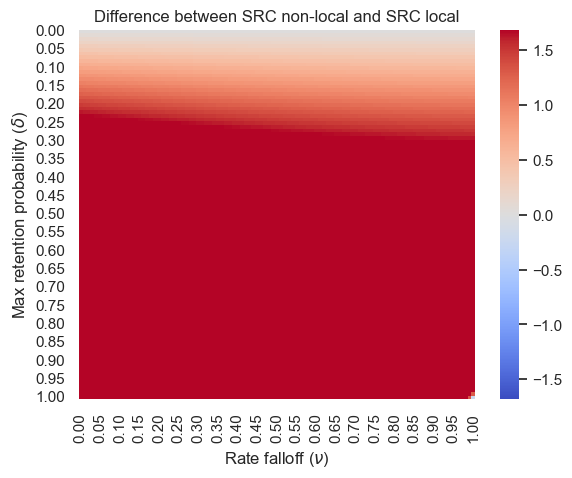

In [9]:
sns.heatmap(
    diffs_srcs_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between SRC non-local and SRC local",
    xlabel = "Rate falloff ($\\nu$)",
    ylabel = "Max retention probability ($\\delta$)"
);

This is in line with the results of Levy et al. (2013), since the model predicts locality for most parameter combinations.

Levy et al. (2013) also looked at the reading time on accusative NPs (in the grammar called 'DO'), and found that these were read slower when placed preverbally than postverbally.

101it [01:28,  1.14it/s]


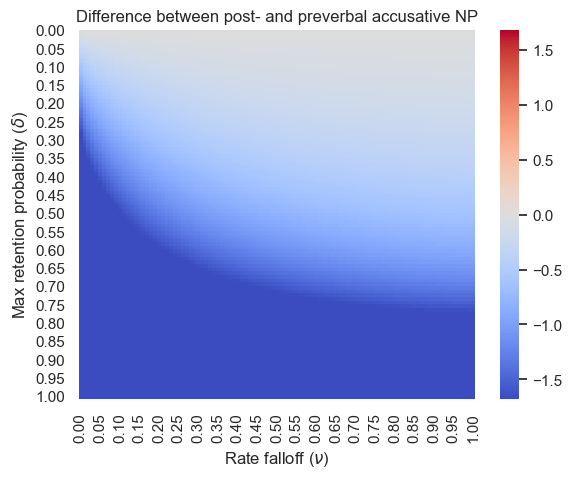

In [10]:
preverbal_acc = model_russian.calculate_processing_difficulty("RPNom DO".split())
postverbal_acc = model_russian.calculate_processing_difficulty("RPNom V DO".split())

diffs_acc_np_russian = gen_diffs("RPNom V DO".split(), "RPNom DO".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

sns.heatmap(
    diffs_acc_np_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between post- and preverbal accusative NP",
    xlabel = "Rate falloff ($\\nu$)",
    ylabel = "Max retention probability ($\\delta$)"
);

As we can see from this output, the model predicts that preverbal accusative NPs have a higher processing difficulty than postverbal accusative NPs. This is to be expected from an expectation-based standpoint, since, as Levy et al. discuss, local SRC configurations are much more common, meaning a comprehender should expect the word following the nominative relative pronoun to be a verb, not a direct object.

### Experiment 1b
Here, I only look at the case-synchretized conditions, which had the following results.

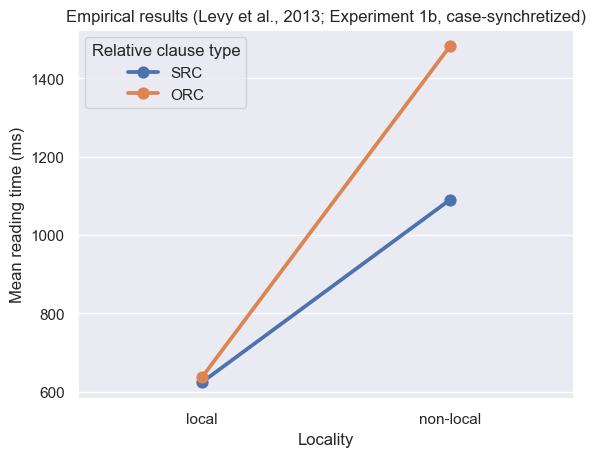

In [11]:
sns.pointplot(expdata.levy_exp1b_verb,
              x = "Locality", 
              y = "Mean reading time (ms)", 
              hue = "Relative clause type"
).set_title("Empirical results (Levy et al., 2013; Experiment 1b, case-synchretized)");

The model predicts the following.

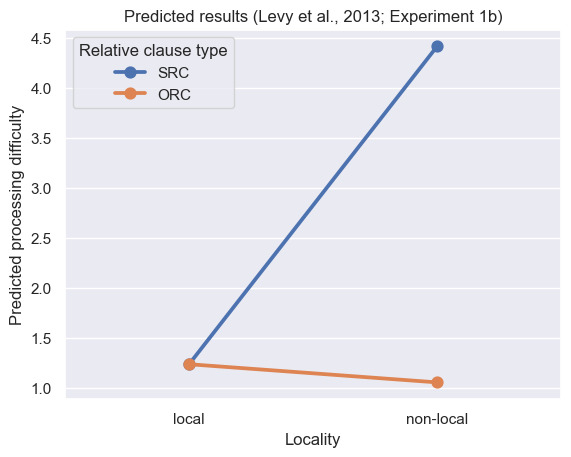

In [12]:
src_cs_local = model_russian.calculate_processing_difficulty("chto V".split(), False)
src_cs_non_local = model_russian.calculate_processing_difficulty("chto DO V".split(), False)

orc_cs_local = model_russian.calculate_processing_difficulty("chto V".split())
orc_cs_non_local = model_russian.calculate_processing_difficulty("chto Subj V".split(), False)

sim_data_exp1b = pd.DataFrame({
    "Predicted processing difficulty": [src_cs_local, src_cs_non_local, orc_cs_local, orc_cs_non_local],
    "Relative clause type": ["SRC", "SRC", "ORC", "ORC"],
    "Locality": ["local", "non-local", "local", "non-local"]
})

sns.pointplot(sim_data_exp1b,
              x = "Locality", 
              y = "Predicted processing difficulty", 
              hue = "Relative clause type"
).set_title("Predicted results (Levy et al., 2013; Experiment 1b)");

This is pretty much the same pattern as the simulated results for Experiment 1a: SRCs show locality and ORCs anti-locality.

In [13]:
diffs_orcs_cs_russian = gen_diffs("chto Subj V".split(), "chto V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs)
diffs_srcs_cs_russian = gen_diffs("chto DO V".split(), "chto V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs)

101it [02:00,  1.19s/it]
101it [01:39,  1.01it/s]


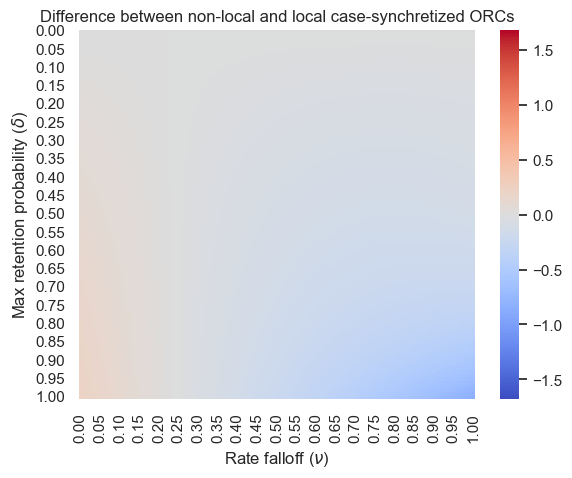

In [14]:
sns.heatmap(
    diffs_orcs_cs_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    vmin = -1.0,
    vmax = 1.0
).set(
    title = "Difference between non-local and local case-synchretized ORCs",
    xlabel = "Rate falloff ($\\nu$)",
    ylabel = "Max retention probability ($\\delta$)"
);

The results differ slightly here from the prediction for case-marked ORCs, where the model was only capable of predicting anti-locality. Here, for small values of the rate falloff $\nu$ the model predicts locality, where the verb is read slower in the non-local condition than in the local condition.

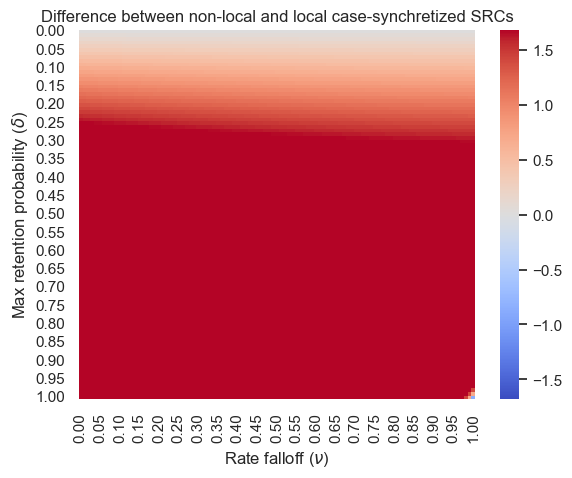

In [15]:
sns.heatmap(
    diffs_srcs_cs_russian,
    xticklabels = xticklabels,
    yticklabels = yticklabels,
    cmap = "coolwarm",
    norm = norm
).set(
    title = "Difference between non-local and local case-synchretized SRCs",
    xlabel = "Rate falloff ($\\nu$)",
    ylabel = "Max retention probability ($\\delta$)"
);

This is practically the same prediction as for case-marked SRCs.

## Experiment 2
The goal of the second experiment was to more directly manipulate the distance between the relative pronoun and the verb. They did this by adding one or two interveners that were either verb arguments (direct object + indirect object) or adjuncts. The results were the following.

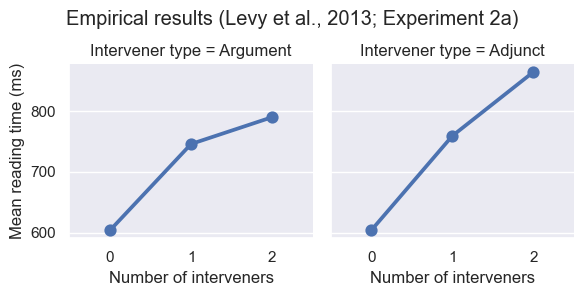

In [16]:
grid = sns.FacetGrid(expdata.levy_exp2a_verb, col = "Intervener type")

grid.map(sns.pointplot, "Number of interveners", "Mean reading time (ms)");
grid.figure.subplots_adjust(top = 0.8);
grid.figure.suptitle("Empirical results (Levy et al., 2013; Experiment 2a)");

In [17]:
no_intv = model_russian.calculate_processing_difficulty("RPNom V".split())
one_arg = model_russian.calculate_processing_difficulty("RPNom DO V".split())
two_arg = model_russian.calculate_processing_difficulty("RPNom DO IO V".split())

one_adj = model_russian.calculate_processing_difficulty("RPNom Adj1 V".split())
two_adj = model_russian.calculate_processing_difficulty("RPNom Adj1 Adj2 V".split())

sim_data_exp2 = pd.DataFrame({
    "Predicted processing difficulty": [no_intv, one_arg, two_arg, no_intv, one_adj, two_adj],
    "Number of interveners": [0, 1, 2, 0, 1, 2],
    "Intervener type": ["Argument", "Argument", "Argument", "Adjunct", "Adjunct", "Adjunct"]
})

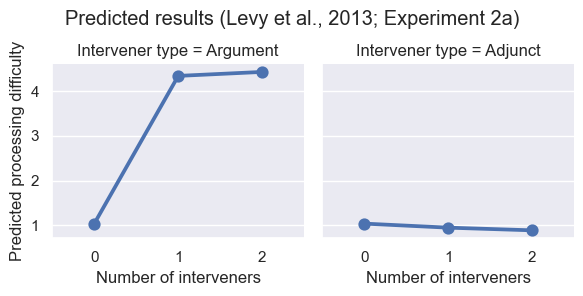

In [18]:
grid = sns.FacetGrid(sim_data_exp2, col = "Intervener type")
grid.map(sns.pointplot, "Number of interveners", "Predicted processing difficulty");
grid.figure.subplots_adjust(top = 0.8);
grid.figure.suptitle("Predicted results (Levy et al., 2013; Experiment 2a)");

We can also have a look at the range of predictable effects.

In [4]:
diffs_arg1_zero = gen_diffs("RPNom DO V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_arg2_arg1 = gen_diffs("RPNom DO IO V".split(), "RPNom DO V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_arg2_zero = gen_diffs("RPNom DO IO V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

diffs_adj1_zero = gen_diffs("RPNom Adj1 V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_adj2_adj1 = gen_diffs("RPNom Adj1 Adj2 V".split(), "RPNom Adj1 V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)
diffs_adj2_zero = gen_diffs("RPNom Adj1 Adj2 V".split(), "RPNom V".split(), pcfg_russian, max_retention_probabilities, rate_falloffs, max_depth = max_depth)

101it [01:30,  1.11it/s]
101it [02:03,  1.22s/it]
101it [01:45,  1.04s/it]
101it [01:36,  1.05it/s]
101it [02:52,  1.71s/it]
101it [02:22,  1.41s/it]


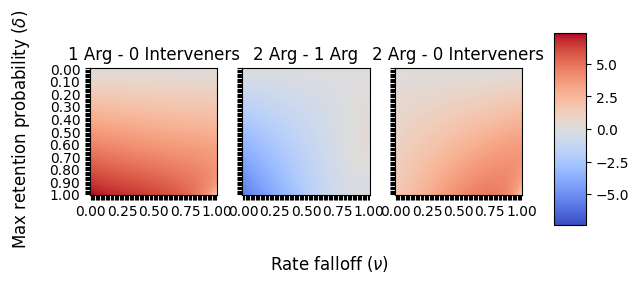

In [33]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

im = axes[0].imshow(diffs_arg1_zero, cmap = "coolwarm", norm = norm)
axes[0].set(
    title = "1 Arg - 0 Interveners",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels_mulmaps,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels_mulmaps
)
axes[0].grid(False)

axes[1].imshow(diffs_arg2_arg1, cmap = "coolwarm", norm = norm)
axes[1].grid(False)
axes[1].set(
    title = "2 Arg - 1 Arg",
)

axes[2].imshow(diffs_arg2_zero, cmap = "coolwarm", norm = norm)
axes[2].grid(False)
axes[2].set(
    title = "2 Arg - 0 Interveners",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
fig.colorbar(im, cax = cbar_ax)

xlabel = fig.supxlabel("Rate falloff ($\\nu$)")
xlabel.set_y(0.2)
ylabel = fig.supylabel("Max retention probability ($\\delta$)")
ylabel.set_x(0)

axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)
axes[2].tick_params(axis="x", labelrotation=45)

plt.show();

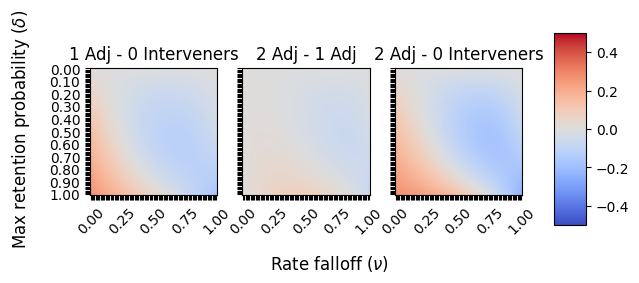

In [37]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True)

min_val = -0.5
max_val = 0.5

im = axes[0].imshow(diffs_adj1_zero, cmap = "coolwarm", vmin = min_val, vmax = max_val)
axes[0].grid(False)
axes[0].set(
    title = "1 Adj - 0 Interveners",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels_mulmaps,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels_mulmaps
)

axes[1].imshow(diffs_adj2_adj1, cmap = "coolwarm", vmin = min_val, vmax = max_val)
axes[1].grid(False)
axes[1].set(
    title = "2 Adj - 1 Adj",
)

axes[2].imshow(diffs_adj2_zero, cmap = "coolwarm", vmin = min_val, vmax = max_val)
axes[2].grid(False)
axes[2].set(
    title = "2 Adj - 0 Interveners",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
fig.colorbar(im, cax = cbar_ax)

xlabel = fig.supxlabel("Rate falloff ($\\nu$)")
xlabel.set_y(0.2)
ylabel = fig.supylabel("Max retention probability ($\\delta$)")
ylabel.set_x(0)

axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)
axes[2].tick_params(axis="x", labelrotation=45)

plt.show();

The predictions are quite varied. The only consistent result is a locality effect when adding one argument intervener. Adding a second argument intervener only leads to more locality (which Levy et al. found) for high $\nu$ values and $\delta$ values around $\sim 0.5\pm 0.2$. Adjunct interveners, on the other hand, lead to locality effects only for small values for $\nu$ and high $\delta$ values, otherwise to anti-locality effects.

A troubling consequence of this is that there is no parameter combination which predicts locality effects for both argument and adjunct interveners, which was the effect that Levy et al. (2013) found. It seems that this model is not adequate to describe this set of effects.

# Interaction between expectation and locality

Let's look at the data from Experiment 2 of Husain et al. and the study by Safavi et al.

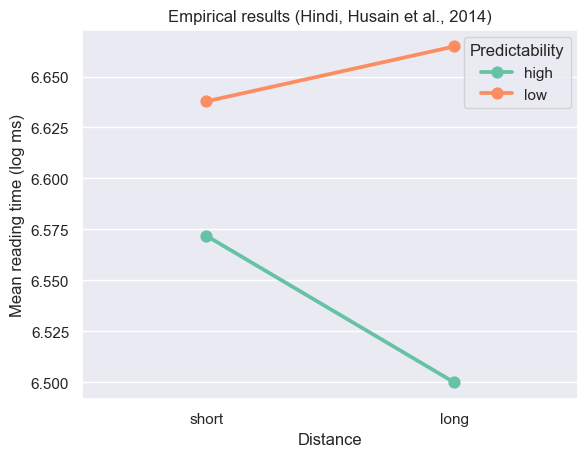

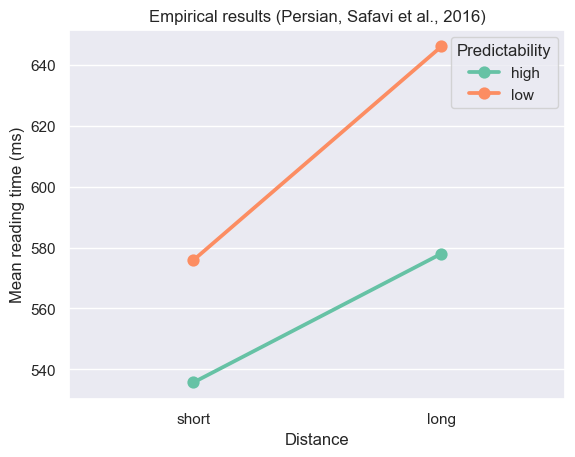

In [6]:
sns.color_palette("Set2")

sns.pointplot(
    expdata.husain_exp2_verb,
    x = "Distance",
    y = "Mean reading time (log ms)",
    hue = "Predictability",
    palette = sns.color_palette("Set2")
).set(
    title = "Empirical results (Hindi, Husain et al., 2014)"
)

plt.show();

sns.pointplot(
    expdata.safavi_exp1_verb,
    x = "Distance",
    y = "Mean reading time (ms)",
    hue = "Predictability",
    palette = sns.color_palette("Set2")
).set(
    title = "Empirical results (Persian, Safavi et al., 2016)"
);

Let's take a look at what the model predicts.

## Persian

In [11]:
pcfg_persian = PCFG.fromstring(
    grammars.gen_hindi_grammar_exp2(
        p_cp = 0.72,
        p_cp_intv = 0.0002,
        p_cp_short = 0.999,
        p_cp_lightverb = 0.64,
        p_sp_intv = 0.02,
        p_sp_short = 0.99,
        p_sp_lightverb = 0.33
    )
)

In [15]:
diffs_preds_persian_cp = gen_diffs("CPNoun Adj1 Adj2 LightVerb".split(), "CPNoun Adj1 LightVerb".split(), pcfg_persian, max_retention_probabilities, rate_falloffs)
diffs_preds_persian_sp = gen_diffs("SPNoun Adj1 Adj2 LightVerb".split(), "SPNoun Adj1 LightVerb".split(), pcfg_persian, max_retention_probabilities, rate_falloffs)

101it [00:14,  6.83it/s]
101it [00:16,  6.16it/s]


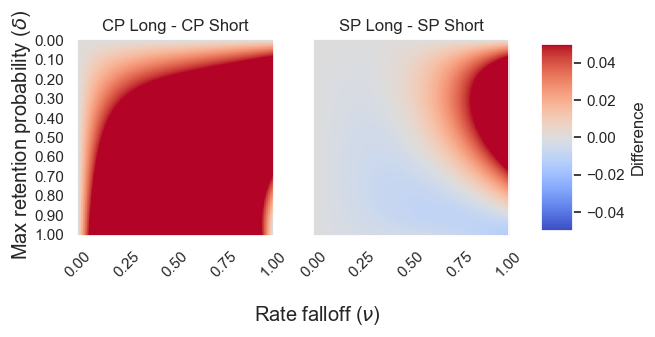

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

im = axes[0].imshow(diffs_preds_persian_cp, cmap = "coolwarm", vmin = -0.05, vmax = 0.05)
axes[0].grid(False)
axes[0].set(
    title = "CP Long - CP Short",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels_mulmaps,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels_mulmaps
)

axes[1].imshow(diffs_preds_persian_sp, cmap = "coolwarm", vmin = -0.05, vmax = 0.05)
axes[1].grid(False)
axes[1].set(
    title = "SP Long - SP Short",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.39])
fig.colorbar(im, cax = cbar_ax).set_label("Difference")

xlabel = fig.supxlabel("Rate falloff ($\\nu$)")
xlabel.set_y(0.1)
ylabel = fig.supylabel("Max retention probability ($\\delta$)")

axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)

plt.show()

The scale is set to be quite small in order for the slight anti-locality effect to be visible for simple predicates. It seems to be the case that complex predicates are consistently predicted to show locality, while the predictions for simple predicates are more mixed.

## Hindi

In [10]:
pcfg_hindi_exp2 = PCFG.fromstring(
    grammars.gen_hindi_grammar_exp2(
        p_cp = 0.5,
        p_cp_intv = 0.05,
        p_cp_short = 0.99,
        p_cp_lightverb = 0.75,
        p_sp_intv = 0.06,
        p_sp_short = 0.99,
        p_sp_lightverb = 0.18
    )
)

In [23]:
diffs_preds_hindi_cp = gen_diffs("CPNoun Adj1 Adj2 LightVerb".split(), "CPNoun Adj1 LightVerb".split(), pcfg_hindi_exp2, max_retention_probabilities, rate_falloffs)
diffs_preds_hindi_sp = gen_diffs("SPNoun Adj1 Adj2 LightVerb".split(), "SPNoun Adj1 LightVerb".split(), pcfg_hindi_exp2, max_retention_probabilities, rate_falloffs)

0it [00:00, ?it/s]

101it [00:16,  6.28it/s]
101it [00:16,  6.01it/s]


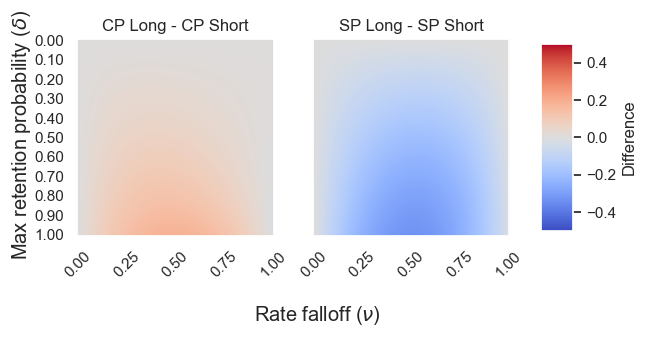

In [25]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

im = axes[0].imshow(diffs_preds_hindi_cp, cmap = "coolwarm", vmin = -0.5, vmax = 0.5)
axes[0].grid(False)
axes[0].set(
    title = "CP Long - CP Short",
    xticks = np.arange(0, len(rate_falloffs)),
    xticklabels = xticklabels_mulmaps,
    yticks = np.arange(0, len(max_retention_probabilities)),
    yticklabels = yticklabels_mulmaps
)

axes[1].imshow(diffs_preds_hindi_sp, cmap = "coolwarm", vmin = -0.5, vmax = 0.5)
axes[1].grid(False)
axes[1].set(
    title = "SP Long - SP Short",
)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.39])
fig.colorbar(im, cax = cbar_ax).set_label("Difference")

xlabel = fig.supxlabel("Rate falloff ($\\nu$)")
xlabel.set_y(0.1)
ylabel = fig.supylabel("Max retention probability ($\\delta$)")

axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)

plt.show()

The model consistently predicts anti-locality for simple predicates and locality for complex predicates, the exact opposite of what Husain et al. (2014) found.

Can we find any parameter combination where there is a locality effect or zero difference for the weakly predictable condition but anti-locality for strongly predictable conditions?

In [29]:
desired_params = []

for i in range(len(max_retention_probabilities)):
    for j in range(len(rate_falloffs)):
        if diffs_preds_hindi_cp[i, j] < 0.0 and diffs_preds_hindi_sp[i, j] >= 0.0:
            desired_params.append((max_retention_probabilities[i], rate_falloffs[j]))

print(len(desired_params))

0


In [30]:
if len(desired_params) == 0:
    raise Exception("No such parameter combination!")

model_hindi_exp2 = toylossy.ProgressiveNoiseModel(pcfg_hindi_exp2, desired_params[0][0], desired_params[0][1])

cp_short_hindi = model_hindi_exp2.calculate_processing_difficulty("CPNoun Adj LightVerb".split())
cp_long_hindi  = model_hindi_exp2.calculate_processing_difficulty("CPNoun Adj Adj LightVerb".split())
sp_short_hindi = model_hindi_exp2.calculate_processing_difficulty("SPNoun Adj LightVerb".split())
sp_long_hindi  = model_hindi_exp2.calculate_processing_difficulty("SPNoun Adj Adj LightVerb".split())

sim_data_hindi = pd.DataFrame({
    "Predicted processing difficulty": [sp_short_hindi, sp_long_hindi, cp_short_hindi, cp_long_hindi],
    "Distance": ["short", "long", "short", "long"],
    "Predictability": ["weak", "weak", "strong", "strong"]
})

sns.pointplot(sim_data_hindi,
              x = "Distance",
              y = "Predicted processing difficulty",
              hue = "Predictability").set_title("Predicted results (Husain et al., 2014)");

Exception: No such parameter combination!

One result was consistent with the empirical findings: a general processing advantage at the light verb for complex predicates compared to simple predicates. The below heatmaps show the difference in average processing difficulty at the verb between complex and simple predicates. The blue color indicates that complex predicate verbs were read faster on average.

0it [00:00, ?it/s]

101it [00:19,  5.25it/s]
101it [00:11,  8.82it/s]
101it [00:20,  4.97it/s]
101it [00:12,  8.08it/s]


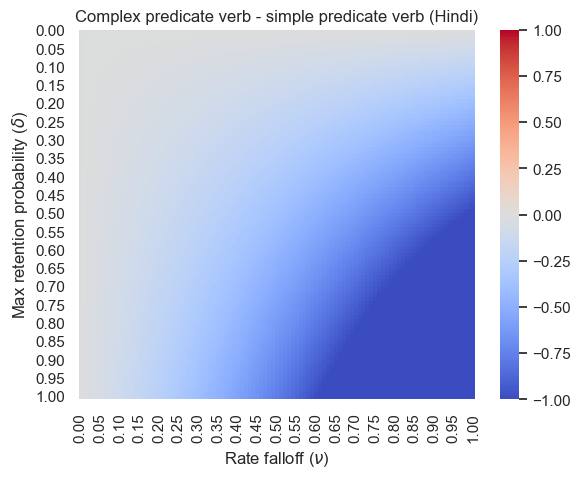

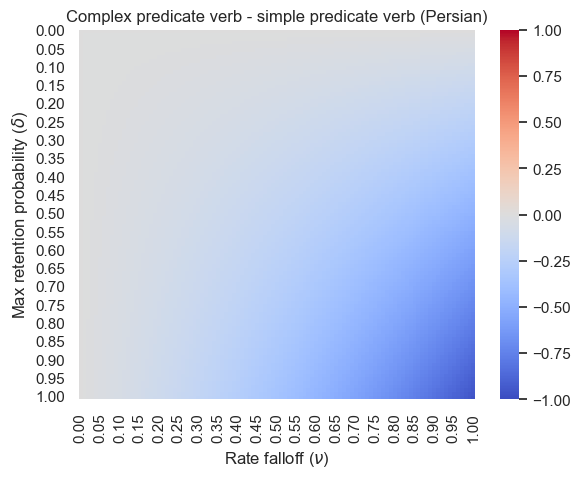

In [18]:
diffs_preds_hindi_cpsp_long  = gen_diffs("CPNoun Adj1 Adj2 LightVerb".split(), "SPNoun Adj1 Adj2 LightVerb".split(), pcfg_hindi_exp2, max_retention_probabilities, rate_falloffs)
diffs_preds_hindi_cpsp_short = gen_diffs("CPNoun Adj1 LightVerb".split(), "SPNoun Adj1 LightVerb".split(), pcfg_hindi_exp2, max_retention_probabilities, rate_falloffs)

avg_diffs_hindi_cpsp = (diffs_preds_hindi_cpsp_long + diffs_preds_hindi_cpsp_short)/2

diffs_preds_persian_cpsp_long  = gen_diffs("CPNoun Adj1 Adj2 LightVerb".split(), "SPNoun Adj1 Adj2 LightVerb".split(), pcfg_persian, max_retention_probabilities, rate_falloffs)
diffs_preds_persian_cpsp_short = gen_diffs("CPNoun Adj1 LightVerb".split(), "SPNoun Adj1 LightVerb".split(), pcfg_persian, max_retention_probabilities, rate_falloffs)

avg_diffs_persian_cpsp = (diffs_preds_persian_cpsp_long + diffs_preds_persian_cpsp_short)/2

sns.heatmap(
    avg_diffs_hindi_cpsp,
    cmap = "coolwarm",
    vmax = 1,
    vmin = -1,
    rasterized = True,
    xticklabels = xticklabels,
    yticklabels = yticklabels
).set(
    title = "Complex predicate verb - simple predicate verb (Hindi)",
    xlabel = "Rate falloff ($\\nu$)",
    ylabel = "Max retention probability ($\\delta$)"
);

plt.show()

sns.heatmap(
    avg_diffs_persian_cpsp,
    cmap = "coolwarm",
    vmax = 1,
    vmin = -1,
    rasterized = True,
    xticklabels = xticklabels,
    yticklabels = yticklabels
).set(
    title = "Complex predicate verb - simple predicate verb (Persian)",
    xlabel = "Rate falloff ($\\nu$)",
    ylabel = "Max retention probability ($\\delta$)"
);